In [1]:

from __future__ import absolute_import, division, print_function

import pandas as pd
import numpy as np
import sklearn as sk
import os
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
# %load_ext autoreload
# %autoreload 2

In [2]:

data = np.load("processed_data.npz")


In [3]:

data.files

['x_train', 'y_train', 'x_test', 'y_test']

In [4]:
data['x_train'].shape

(153582, 47)

In [5]:
data['y_train'].shape

(153582, 46)

In [6]:
input_dim = data['x_train'].shape[1]-1
encoding_dim = 10

compression_factor = float(input_dim) / encoding_dim
print("Compression factor: %s" % compression_factor)
def sampling(args):
    import tensorflow as tf
    z_mean, z_log_var = args
    batch = tf.keras.backend.shape(z_mean)[0]
    dim = tf.keras.backend.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    print(epsilon)
    return z_mean + tf.keras.backend.exp(0.5 * z_log_var) * epsilon
inputs = tf.keras.layers.Input(shape=(input_dim,), name='encoder_input')
x_1 = tf.keras.layers.Dense(40, input_shape=(input_dim,), activation='relu')(inputs)
x_2 = tf.keras.layers.Dense(35, activation='relu')(x_1)
x_3 =  tf.keras.layers.Dense(30, activation='relu')(x_2)
z_mean = tf.keras.layers.Dense(30, name='z_mean')(x_3)
z_log_var = tf.keras.layers.Dense(30, name='z_log_var')(x_3)
z = tf.keras.layers.Lambda(sampling, output_shape=(1,), name='z')([z_mean, z_log_var])
d_1 = tf.keras.layers.Dense(40, activation='relu')(z)
d_2 = tf.keras.layers.Dense(45, activation='relu')(d_1)
d_3 = tf.keras.layers.Dense(46)(d_2)

vae = tf.keras.models.Model(inputs, d_3, name='vae')
vae.summary()


Compression factor: 4.6
Tensor("z/random_normal:0", shape=(?, 30), dtype=float32)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 46)           0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 40)           1880        encoder_input[0][0]              
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 35)           1435        dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 30)           1080        dense_2[0][0]                    
___________________________

In [8]:
from time import time
def true_loss(y_true, y_pred, z_mean, z_log_var):
    reconstruction_loss = tf.keras.losses.mean_squared_error(y_true, y_pred)
    reconstruction_loss *= 1
    kl_loss = -0.5 * tf.keras.backend.mean(1 + z_log_var - tf.keras.backend.square(z_mean) - tf.keras.backend.exp(z_log_var), axis=1)
    #kl_loss = tf.keras.backend.sum(kl_loss, axis=-1)
    #kl_loss *= -1
    return tf.keras.backend.mean(reconstruction_loss + kl_loss * 0.0)

def sub_loss(z_mean, z_log_var):
    print(z_mean)
    print(z_log_var)
    def loss_func(y_true, y_pred):
        return true_loss(y_true, y_pred, z_mean, z_log_var)
    return loss_func

tensorboard = keras.callbacks.TensorBoard(log_dir="logs/vae_{}".format(time()))
cp_callback = tf.keras.callbacks.ModelCheckpoint("vae_noklloss.model",
                                                 verbose=1, monitor='val_loss', save_best_only=True)

early_stop =tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

vae.compile(optimizer='adam', loss = sub_loss(z_mean, z_log_var))
vae.fit(data['x_train'][:,:][:,:-1], data['x_train'][:,:][:,:-1],
                epochs=50,
                shuffle=True,
                validation_data=(data['x_train'][:,:][:,:-1],data['x_train'][:,:][:,:-1]), callbacks=[tensorboard, cp_callback, early_stop])

Tensor("z_mean/BiasAdd:0", shape=(?, 30), dtype=float32)
Tensor("z_log_var/BiasAdd:0", shape=(?, 30), dtype=float32)
Train on 153582 samples, validate on 153582 samples
Epoch 1/50
153582/153582 [==============================] - 12s 81us/step - loss: 0.3922 - val_loss: 0.2684

Epoch 00001: val_loss improved from inf to 0.26840, saving model to vae_noklloss.model
Epoch 2/50
153582/153582 [==============================] - 13s 85us/step - loss: 0.2278 - val_loss: 0.1957

Epoch 00002: val_loss improved from 0.26840 to 0.19565, saving model to vae_noklloss.model
Epoch 3/50
153582/153582 [==============================] - 13s 86us/step - loss: 0.1792 - val_loss: 0.1670

Epoch 00003: val_loss improved from 0.19565 to 0.16698, saving model to vae_noklloss.model
Epoch 4/50
153582/153582 [==============================] - 15s 98us/step - loss: 0.1643 - val_loss: 0.1566

Epoch 00004: val_loss improved from 0.16698 to 0.15660, saving model to vae_noklloss.model
Epoch 5/50
153582/153582 [=========

In [39]:
vae_model = tf.keras.models.load_model("vae_noklloss.model", compile=False)

input_img = tf.keras.layers.Input(shape=(input_dim,))
encoder_layer1 = vae_model.layers[0]
encoder_layer2 = vae_model.layers[1]
encoder_layer3 = vae_model.layers[2]
encoder_layer4 = vae_model.layers[3]
encoder_layer5 = vae_model.layers[4]
encoder_layer6 = vae_model.layers[5]
encoder_layer7 = vae_model.layers[6]
intermediate = encoder_layer4(encoder_layer3(encoder_layer2(encoder_layer1(input_img))))
output = encoder_layer7([encoder_layer5(intermediate), encoder_layer6(intermediate)])
encoder = tf.keras.Model(input_img, output)
#encoder = tf.keras.Model(input_img, encoder_layer1(input_img))
encoder.summary()

Tensor("z_6/random_normal:0", shape=(?, 30), dtype=float32)
Tensor("z_6/random_normal_1:0", shape=(?, 30), dtype=float32)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 46)           0                                            
__________________________________________________________________________________________________
encoder_input (InputLayer)      (None, 46)           0           input_7[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 40)           1880        encoder_input[1][0]              
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 35)           1435        dense_1[1][0]        

In [40]:
input_img_d = tf.keras.layers.Input(shape=(30,))
#input_img_d = tf.keras.layers.Input(shape=(input_dim,))
decoder_layer1 = vae_model.layers[7]
decoder_layer2 = vae_model.layers[8]
decoder_layer3 = vae_model.layers[9]
decoder = tf.keras.Model(input_img_d, decoder_layer3(decoder_layer2(decoder_layer1(input_img_d))))
#decoder = tf.keras.Model(input_img_d, decoder_layer1(input_img_d))
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 30)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 40)                1240      
_________________________________________________________________
dense_5 (Dense)              (None, 45)                1845      
_________________________________________________________________
dense_6 (Dense)              (None, 46)                2116      
Total params: 5,201
Trainable params: 5,201
Non-trainable params: 0
_________________________________________________________________


In [41]:
def get_embedded(not_embedded_data):
    embedded = encoder.predict(not_embedded_data[:,:][:,:-1])
    return np.append(embedded, not_embedded_data[:][:,-1].reshape(embedded.shape[0], 1), axis=1)


In [42]:
print(data['y_train'])

[[-0.05892545  0.76765437 -0.29766279 ...  0.3906546   1.00764494
   1.46158188]
 [-0.05892545  0.76765437 -0.29766279 ...  0.3906546   1.00764494
   1.46158188]
 [-0.4871765   0.27141224 -0.29766279 ...  0.3906546   1.00764494
   1.46158188]
 ...
 [-0.05892545 -0.72107202  0.28859736 ...  0.3906546   0.70272735
   1.46158188]
 [-0.05892545 -0.47295096  1.07027757 ...  0.3906546   0.70272735
   1.46158188]
 [-0.05892545 -0.47295096  1.07027757 ...  0.3906546   0.70272735
   1.46158188]]


In [43]:
print(decoder.predict(encoder.predict(data['y_train'])))

[[ 0.00544943  0.54063225 -0.19724932 ...  0.36457083  1.054631
   1.4833385 ]
 [-0.03390406  0.5378956  -0.18335104 ...  0.36815187  1.0503498
   1.4843906 ]
 [-0.2525407   0.16020894 -0.16890542 ...  0.35872942  1.0571091
   1.4938413 ]
 ...
 [-0.5743013  -0.43718147 -0.14386004 ...  0.37439018  0.62824035
   1.4406801 ]
 [-0.67913914 -0.44752467 -0.1561488  ...  0.36937112  0.6387595
   1.4808222 ]
 [-0.67913926 -0.4475243  -0.15614885 ...  0.36937076  0.63875985
   1.4808232 ]]


In [44]:
x_test_e = get_embedded(data['x_test'])
y_test_e = encoder.predict(data['y_test'])
x_train_e = get_embedded(data['x_train'])
y_train_e = encoder.predict(data['y_train'])

In [45]:
np.savez("embedded_data_vae_nokl.npz", x_train_e=x_train_e, y_train_e=y_train_e, 
        x_test_e=x_test_e, y_test_e=y_test_e, x_train = data['x_train'], x_test=data['x_test']
         , y_train=data['y_train'], y_test=data['y_test'] )



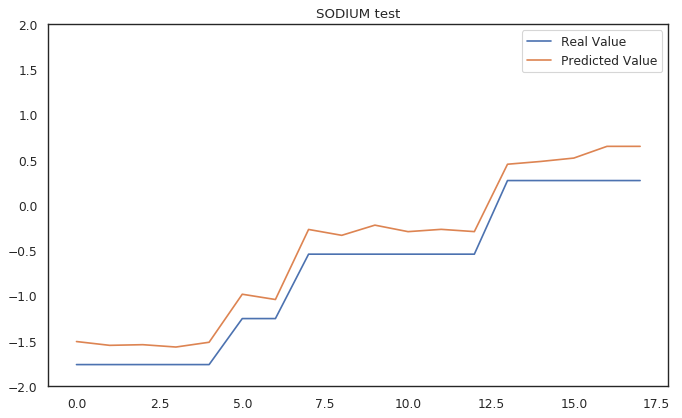

In [46]:
sns.set(style="white")

columns = ['ALBUMIN', 'ANION GAP', 'BANDS', 'BICARBONATE',
       'BILIRUBIN', 'BUN', 'CHLORIDE', 'CREATININE', 'DiasBP', 'Glucose',
       'GLUCOSE', 'HeartRate', 'HEMATOCRIT', 'HEMOGLOBIN', 'INR', 'LACTATE',
       'MeanBP', 'PaCO2', 'PLATELET', 'POTASSIUM', 'PT', 'PTT', 'RespRate',
       'SODIUM', 'SpO2', 'SysBP', 'TempC', 'WBC', 'age', 'is_male',
       'race_white', 'race_black', 'race_hispanic', 'race_other', 'height',
       'weight', 'vent', 'sofa', 'lods', 'sirs', 'qsofa', 'qsofa_sysbp_score',
       'qsofa_gcs_score', 'qsofa_resprate_score', 'elixhauser_hospital',
       'blood_culture_positive']
import matplotlib.pyplot as plt
def plot(column, mode, prediction):
    from matplotlib.pyplot import figure
    figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.plot(data['y_'+mode][6:24,columns.index(column)], label="truth", scaley=False)
    plt.plot(prediction[6:24,columns.index(column)], label="predicted", scaley=False)
    plt.ylim(-2, 2)
    plt.legend(["Real Value", "Predicted Value"])
    plt.title(column + " " + mode)
    plt.show()
plot('SODIUM', "test", decoder.predict(encoder.predict(data['y_test'])))


In [47]:
encoder.compile(optimizer='adam', loss='mean_squared_error')
encoder.save("encoder_variational_nokl.model")

decoder.compile(optimizer='adam', loss='mean_squared_error')
decoder.save("decoder_variational_nokl.model")


In [48]:
model = tf.keras.models.load_model("decoder_variational.model")
model.predict(encoder.predict(data['y_test']))

array([[-0.53370553, -0.49518147, -0.30292875, ..., -2.517274  ,
         0.11490536, -0.59006643],
       [-0.44085032, -0.4393787 , -0.31650174, ..., -2.6986556 ,
        -0.00992244, -0.48343566],
       [-0.26546365, -0.13308185, -0.30784124, ..., -2.5882983 ,
        -0.23204666, -0.42347816],
       ...,
       [-0.65442735, -1.4738529 , -0.38338375, ...,  0.49780506,
        -0.77206904, -2.887403  ],
       [-0.65859205, -1.5426874 , -0.42308527, ...,  0.49102432,
        -0.76845497, -2.8560984 ],
       [-0.658591  , -1.5426844 , -0.42308545, ...,  0.49102467,
        -0.768453  , -2.856098  ]], dtype=float32)